# Letters

## Description

Generate an image with the edges of the letters present in this noisy image

## Group 5
- Francisco Macedo Ferreira PG55942
- Júlio José Medeiros Pereira Pinto PG57883
- Ivan Sérgio Rocha Ribeiro PG55950



In [325]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np

fname = 'Letters-noisy.png'
operations = {}
pipeline_order = []
masks = []
notch_filters = []

# Operations

### IDFT


In [326]:
def compute_idft(dft):
    dft = np.fft.ifftshift(dft)
    img_back = cv2.idft(dft)
    magnitude = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
    # Normalize and convert to uint8
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return magnitude.astype(np.uint8)

operations['idft'] = compute_idft
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>}


### DTF

In [327]:
def compute_dft(img):
    # Convert image to float32 if needed
    if img.dtype != np.float32:
        img = np.float32(img)
    
    dft = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)
    return np.fft.fftshift(dft)

operations['dft'] = compute_dft
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>}


### Inpaint (Black and White)

To remove the black and white pixels we decided to use the function inpaint from OpenCV. It allows us to use different interpolation methods. We decided to use Telea’s Fast Marching Method (`cv2.INPAINT_TELEA`).

In [328]:
# Inpainting
def inpaint_image(img):
    mask = (img == 0) | (img == 255)
    mask = mask.astype(np.uint8) * 255
    
    return cv2.inpaint(img, mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

operations['inpaint'] = inpaint_image
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>}


### Paint


In [329]:
def paint_image_mask(img):
    # Apply a mask and paint where its black in the mask
    if masks:
        mask = masks[1]
        img[mask == 0] = 128
        
    return img
    
operations['paint'] = paint_image_mask
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>}


### Binarization

In [330]:
def binarize_pixels(image_array):

    # Create a copy of the array to avoid modifying the original
    binary_image = image_array.copy()
    # Set values > 125 to 0 (black)
    binary_image[image_array > 200] = 255
    # Set values <= 125 to 255 (white)
    binary_image[image_array <= 200] = 0
    
    return binary_image

operations['binarize'] = binarize_pixels
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>}


### Threshold Filter

In [ ]:
def apply_thresholding(img, plots=False, inpaint=True):
    # Ensure we're working with float32 in range [0,1]
    if img.max() > 1.0:
        img = img / 255.0

    # Convert to uint8 for proper bitwise inversion
    img_uint8 = (img * 255).astype(np.uint8)
    
    inverted_img = cv2.bitwise_not(img_uint8)  # Now it's uint8

    # Calculate histogram directly on float32 data
    hist_float = np.histogram(img, bins=256, range=(0,1))[0]

    # Apply different thresholding methods
    _, Gthres = cv2.threshold(inverted_img.astype(np.float32) / 255.0, 0.2, 1.0, cv2.THRESH_BINARY)

    # Otsu's method requires uint8 input
    _, Othres = cv2.threshold(inverted_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    Othres = Othres.astype(np.float32) / 255.0  # Normalize back

    # Adaptive thresholding also needs uint8
    Athres = cv2.adaptiveThreshold(inverted_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 1)
    Athres = Athres.astype(np.float32) / 255.0

    masks.clear()
    masks.append(Gthres)
    masks.append(Othres)
    masks.append(Athres)

    if plots:
        fig, axs = plt.subplots(3, 2, figsize=(12, 24))
        axs[0, 0].imshow(img, cmap='gray')
        axs[0, 0].set_title('Original')
        axs[0, 0].axis('off')

        axs[0, 1].plot(hist_float)
        axs[0, 1].set_title('Histogram')
        axs[0, 1].axis('off')

        axs[1, 0].imshow(Gthres, cmap='gray')
        axs[1, 0].set_title('Global Thresholding')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(Othres, cmap='gray')
        axs[1, 1].set_title('Otsu Thresholding')
        axs[1, 1].axis('off')

        axs[2, 0].imshow(Athres, cmap='gray')
        axs[2, 0].set_title('Adaptive Thresholding')
        axs[2, 0].axis('off')

        plt.show()

    # Invert the Otsu threshold mask before applying it
    inverted_mask = cv2.bitwise_not((Othres * 255).astype(np.uint8))

    # Apply mask with the inverted version
    result = apply_mask(img_uint8, inverted_mask, True, inpaint)

    return result

def apply_thresholding_noinpaint(img):
    return apply_thresholding(img, plots=True, inpaint=False)

# Adiciona ao dicionário de operações
operations['thresholding_inpaint'] = apply_thresholding
operations['thresholding'] = apply_thresholding_noinpaint


### Gaussian Blurs


In [360]:

def apply_gaussian_blur(img):
        
    # Apply Gaussian blur to the entire image
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Create a copy of the original image
    result_img = img.copy()
    
    # Apply the blurred image only where masks[1] is
    if(masks.__len__() > 1): 
        result_img[masks[1] == 0] = blurred_img[masks[1] == 0]

    return result_img

# Example usage
operations['gaussian'] = apply_gaussian_blur
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3dbd440>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>, 'high_pass': <function apply_high_pass_filter at 0x7d62e3fbd1c0>, 'unsharp': <function apply_unsharp_mask at 0x7d62e2bd9760>, 'sharpen': <function sharpen at 0x7d62e3fbd120>, 'no

### Sobel Magnitude

In [333]:
def sobel_mag(img):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    image = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    
    # Normalize and convert to uint8
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    image = np.bitwise_not(image)
    return image

operations['sobel'] = sobel_mag
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>}


### Bilateral Filter

In [334]:
def apply_bilateral_filter(image):
    # guarantee is the correct image type
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.bilateralFilter(image, d=15, sigmaColor=90, sigmaSpace=90)

operations['bilateral'] = apply_bilateral_filter
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>}


### CLAHE

In [335]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    # Convert to uint8 if not already
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    processed_image = clahe.apply(image)
    
    # Keep output as uint8 since many OpenCV functions work better with uint8
    return processed_image

operations['clahe'] = apply_clahe
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>}


### Canny Edges


In [336]:
def apply_canny_edges(img):
    # Ensure we're working with float32 in range [0,1]
    if img.max() > 1.0:
        img = img / 255.0

    # Convert to uint8 for proper bitwise inversion
    img_uint8 = (img * 255).astype(np.uint8)
    
    # Apply Canny edge detection
    edges = cv2.Canny(img_uint8, 100, 200)
    
    return edges.astype(np.float32) / 255.0

operations['canny'] = apply_canny_edges

### Gamma Correction

In [337]:
def gammaCorrection(src):
    invGamma = 1 / 2.2
    
    src = np.bitwise_not(src)

    # Ensure input is in uint8 format for cv2.LUT()
    src_uint8 = (src * 255).clip(0, 255).astype(np.uint8) if src.dtype != np.uint8 else src

    # Create lookup table for gamma correction
    table = np.array([((i / 255) ** invGamma) * 255 for i in range(256)], dtype=np.uint8)

    # Apply gamma correction
    corrected_uint8 = cv2.LUT(src_uint8, table)
    
    img = np.bitwise_not(corrected_uint8)

    return img

operations['gamma'] = gammaCorrection


## Frequency Filters

### Low-Pass Frequency Filter

We tested with both a circular center as well as rectangular, it didn´t impact the image as much as we would like

In [338]:
def apply_low_pass_filter(dft, order=2, cutoff=30):
    # Ensure dft is float32
    if dft.dtype != np.float32:
        dft = np.float32(dft)
    
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    # Create meshgrid of coordinates
    u = np.arange(rows) - crow
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(v, u)
    
    # Calculate distance from center
    D = np.sqrt(U**2 + V**2)
    
    # Butterworth low-pass filter
    H = 1 / (1 + (D / cutoff)**(2*order))
    
    # Create complex filter
    mask = np.stack([H, H], axis=2).astype(np.float32)
    
    # Ensure output is float32
    return (dft * mask).astype(np.float32)

operations['low_pass'] = apply_low_pass_filter
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>}


### High-Pass Frequency Filter

It was rather useless but we though we might as well try.

In [339]:
def apply_high_pass_filter(dft, order=2, cutoff=60):
    # Ensure dft is float32
    if dft.dtype != np.float32:
        dft = np.float32(dft)
        
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    # Create meshgrid of coordinates
    u = np.arange(rows) - crow
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(v, u)
    
    # Calculate distance from center
    D = np.sqrt(U**2 + V**2)
    
    # Butterworth high-pass filter with increased cutoff
    H = 1 / (1 + (cutoff / (D + 1e-6))**(2*order))
    
    # Create complex filter
    mask = np.stack([H, H], axis=2).astype(np.float32)
    
    # Ensure output is float32
    return (dft * mask).astype(np.float32)

operations['high_pass'] = apply_high_pass_filter
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>, 'high_pass': <function apply_high_pass_filter at 0x7d62e3fbd1c0>}


### Unsharp Mask


In [340]:
def apply_unsharp_mask(dft, sigma=1.0, strength=1.5):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2

    mask = np.ones((rows, cols, 2), np.float32) 
    
    cv2.circle(mask, (ccol, crow), int(sigma * min(rows, cols)), (1 + strength, 1 + strength), -1)

    sharpened_dft = dft * mask

    return sharpened_dft

operations['unsharp'] = apply_unsharp_mask
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>, 'high_pass': <function apply_high_pass_filter at 0x7d62e3fbd1c0>, 'unsharp': <function apply_unsharp_mask at 0x7d62e2bd9760>}


### Sharpen


In [341]:
def sharpen(image):
    # Convert to uint8 if not already
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    
    # Define the sharpening kernel
    kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ], dtype=np.float32)
    
    # Apply the kernel using filter2D
    sharpened_image = cv2.filter2D(image, -1, kernel)
    
    # Ensure output is uint8
    return np.clip(sharpened_image, 0, 255).astype(np.uint8)

operations['sharpen'] = sharpen

## Notch Filters

### Regular Notch Filter

In terms of removing the "checkboard" like effect this was one of the most useful approaches

In [342]:



# Apply Notch Filter
def apply_notch_filter(dft, i):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [[ (ccol - 30, crow + 20, 10), (ccol + 30, crow - 20, 10), (ccol + 30, crow + 20, 10), (ccol - 30, crow - 20, 10),
                   (ccol + 20, crow, 5), (ccol - 20, crow, 5), (ccol - 5, crow + 10, 5), (ccol + 5, crow - 10, 5)
                 ],
                 [ (ccol - 30, crow + 20, 10), (ccol + 30, crow - 20, 10),
                  (ccol + 20, crow, 5), (ccol - 20, crow, 5), (ccol - 5, crow + 10, 5), (ccol + 5, crow - 10, 5)
                 ],
                 [ (ccol + 30, crow + 20, 10), (ccol - 30, crow - 20, 10), (ccol + 15, crow - 15, 5), (ccol - 15, crow + 15, 5)]
                ]

    center = notch_centers[i]
    
    mask = np.ones((rows, cols, 2), np.uint8)
    for x, y, r in center:
        cv2.circle(mask, (x, y), r, (0, 0), -1)
    
    return dft * mask

def apply_notch0(dft):
    return apply_notch_filter(dft, 0)

def apply_notch1(dft):
    return apply_notch_filter(dft, 1)

def apply_notch2(dft):
    return apply_notch_filter(dft, 2)

operations['notch0'] = apply_notch0
operations['notch1'] = apply_notch1
operations['notch2'] = apply_notch2
print(operations)


{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>, 'high_pass': <function apply_high_pass_filter at 0x7d62e3fbd1c0>, 'unsharp': <function apply_unsharp_mask at 0x7d62e2bd9760>, 'sharpen': <function sharpen at 0x7d62e3fbd120>, 'no

### Donut Notch Filter

Just something different we decided to try.


In [343]:
# Apply Donut Notch Filter
def apply_donut_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [(ccol - 30, crow - 20, 10, 30), (ccol + 30, crow + 20, 10, 30)]
    
    mask = np.ones((rows, cols, 2), np.uint8)
    
    for x, y, r_inner, r_outer in notch_centers:
        cv2.circle(mask, (x, y), r_outer, (0, 0), -1)
        cv2.circle(mask, (x, y), r_inner, (1, 1), -1)
    return dft * mask

operations['donut'] = apply_donut_notch_filter
print(operations)


{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>, 'high_pass': <function apply_high_pass_filter at 0x7d62e3fbd1c0>, 'unsharp': <function apply_unsharp_mask at 0x7d62e2bd9760>, 'sharpen': <function sharpen at 0x7d62e3fbd120>, 'no

### Inverted Notch Filter

Very much like the Low-Pass filter, but this implementations give us a bit more of a way to test it. We tested it with the regular notch_centers array from the Notch Center Function but it looked awful.

In [344]:

# Apply Inversed Notch Filter
def apply_inversed_notch_filter(dft):
    rows, cols = dft.shape[:2]
    crow, ccol = rows // 2, cols // 2
    
    notch_centers = [(ccol, crow, 50)]

    mask = np.zeros((rows, cols, 2), np.uint8)
    for x, y, r in notch_centers:
        cv2.circle(mask, (x, y), r, (1, 1), -1)
    return dft * mask

operations['inversed_notch'] = apply_inversed_notch_filter
print(operations)

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>, 'high_pass': <function apply_high_pass_filter at 0x7d62e3fbd1c0>, 'unsharp': <function apply_unsharp_mask at 0x7d62e2bd9760>, 'sharpen': <function sharpen at 0x7d62e3fbd120>, 'no

# Helper Functions


### Load Image & Analyzing


{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3fbce00>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>, 'high_pass': <function apply_high_pass_filter at 0x7d62e3fbd1c0>, 'unsharp': <function apply_unsharp_mask at 0x7d62e2bd9760>, 'sharpen': <function sharpen at 0x7d62e3fbd120>, 'no

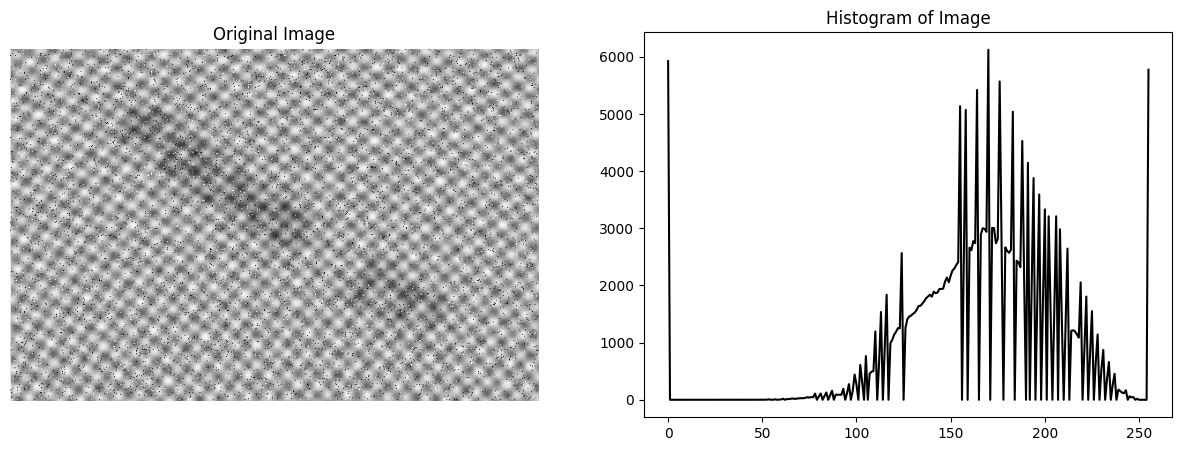

In [345]:

def analyze_image(img):
    hist = cv2.calcHist([img.astype(np.uint8)], [0], None, [256], [0, 256])
    return hist

def apply_analyze_image(img):
    hist = analyze_image(img)
    # Just the histogram
    plt.plot(hist, color='black')
    plt.title('Histogram of Image')
    plt.show()

    return img

operations['analyze'] = apply_analyze_image
print(operations)


def load_image(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    hist = analyze_image(img)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].plot(hist, color='black')
    axes[1].set_title('Histogram of Image')
    plt.show()

    return np.float32(img)

data = load_image(fname)

### Plots


In [346]:
def plot_result(data, title):
    if data.ndim == 2:  # Spatial domain
        plt.figure()
        plt.title(title)
        plt.imshow(data, cmap='gray')
        plt.axis('off')
        plt.show()
    elif data.ndim == 3 and data.shape[-1] == 2:  # Frequency domain
        magnitude_spectrum = 20 * np.log(cv2.magnitude(data[:, :, 0], data[:, :, 1]) + 1)
        img = compute_idft(data)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Reconstructed Image')
        axes[0].axis('off')
        
        axes[1].imshow(magnitude_spectrum, cmap='gray')
        axes[1].set_title('Magnitude Spectrum')
        axes[1].axis('off')
        plt.show()

### Masks Function

In [347]:
def apply_mask(img, mask, inverted=False, inpaint=True):
    """
    Aplica uma máscara binária a uma imagem.

    Parâmetros:
    - img: numpy array, imagem de entrada (grayscale ou colorida).
    - mask: numpy array, máscara binária (0 e 255).
    - inverted: bool, se True, aplica a máscara invertida (mantém áreas pretas).

    Retorna:
    - Imagem mascarada com fundo preto.
    """
    # Garantir que a máscara seja binária (0 e 255)
    mask = (mask > 0).astype(np.uint8) * 255  

    # Inverter a máscara se necessário
    if inverted:
        mask = cv2.bitwise_not(mask)

    # Se a imagem for colorida, converter a máscara para 3 canais
    if len(img.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Aplicar a máscara à imagem
    result = cv2.bitwise_and(img, mask)
    
    # Set masked-out areas to white (255)
    if inpaint:
        result = inpaint_image(result)
    else:
        result[mask == 0] = 255
    
    return result

# Main Function

In [353]:
print(operations)
print(masks)

def run_pipeline(data, pipe, debug=True, finished=True):
    for step in pipe:
        data = operations[step](data)
        if debug:
            print(f"Step: {step}")
            print(f"Data type: {data.dtype}")
            plot_result(data, step)

    if finished:
        plot_result(data, "Final Result")
        print("Pipeline completed!")
        
    return data

{'idft': <function compute_idft at 0x7d62e3fbca40>, 'dft': <function compute_dft at 0x7d62e3fbcae0>, 'inpaint': <function inpaint_image at 0x7d62e3fbc720>, 'paint': <function paint_image_mask at 0x7d62e198fd80>, 'binarize': <function binarize_pixels at 0x7d62e3fbc2c0>, 'thresholding_inpaint': <function apply_thresholding at 0x7d62e3fbcf40>, 'thresholding': <function apply_thresholding_noinpaint at 0x7d62e3fbc180>, 'gaussian': <function apply_gaussian_blur at 0x7d62e3845760>, 'sobel': <function sobel_mag at 0x7d62e3fbc860>, 'bilateral': <function apply_bilateral_filter at 0x7d62e198d120>, 'clahe': <function apply_clahe at 0x7d62e3fbcd60>, 'canny': <function apply_canny_edges at 0x7d62e283cb80>, 'gamma': <function gammaCorrection at 0x7d62e1c56c00>, 'low_pass': <function apply_low_pass_filter at 0x7d62e283c220>, 'high_pass': <function apply_high_pass_filter at 0x7d62e3fbd1c0>, 'unsharp': <function apply_unsharp_mask at 0x7d62e2bd9760>, 'sharpen': <function sharpen at 0x7d62e3fbd120>, 'no

### Multilpe Pipeline Tests

All pipelines completed!


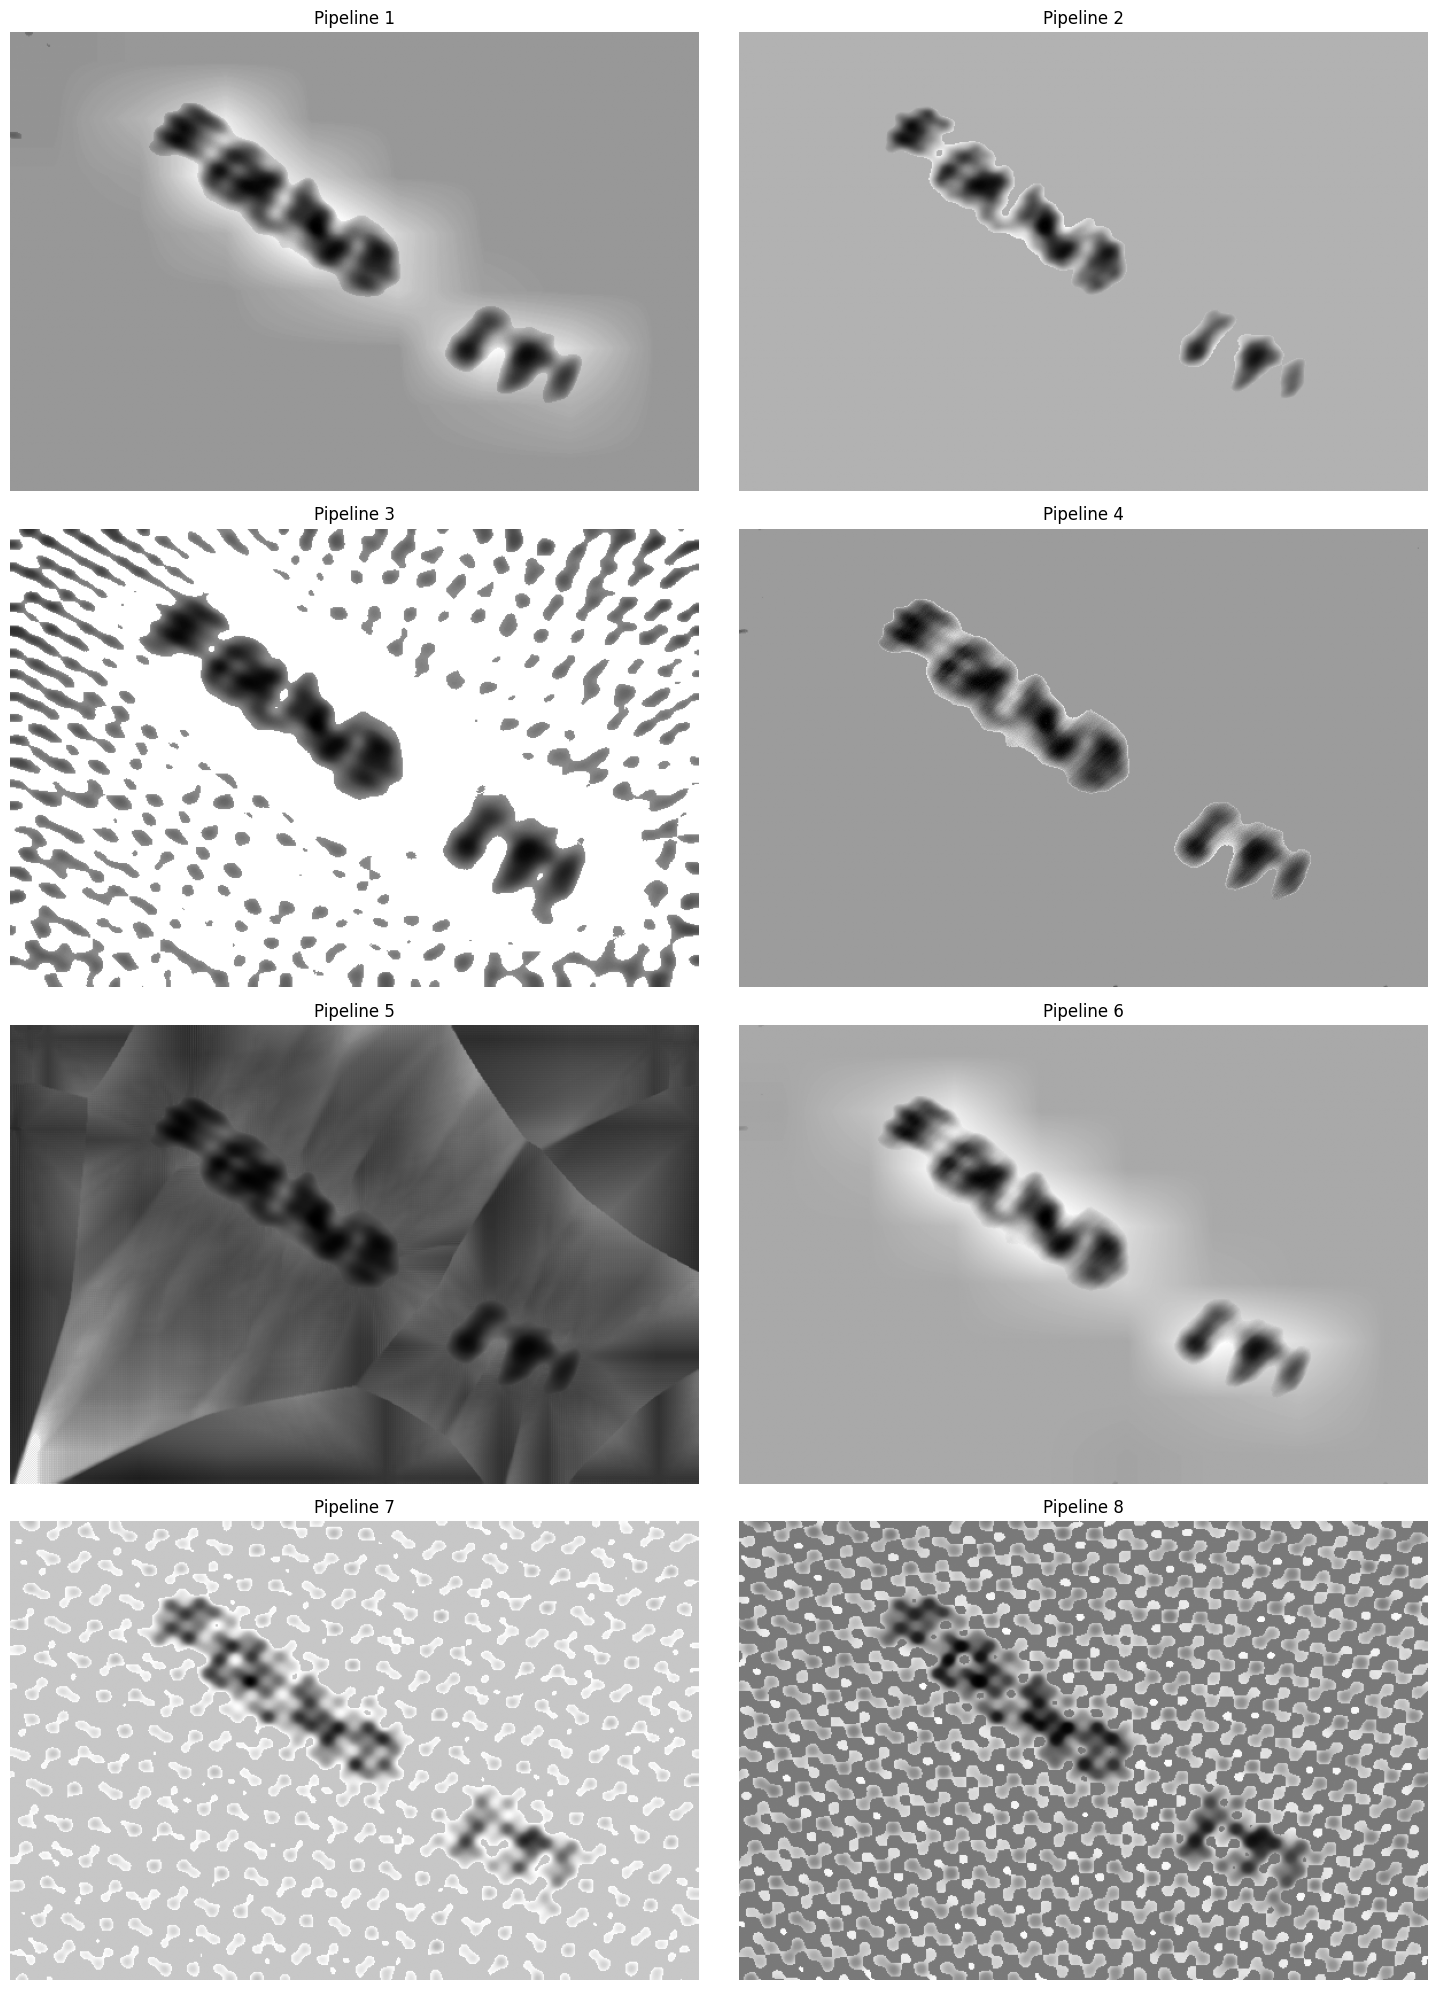

In [362]:
pipelines = [

    ["inpaint", "dft", "notch0", "low_pass", "idft", "bilateral", "thresholding_inpaint", "paint", "clahe", "gamma"],
    ["inpaint", "dft", "notch1", "low_pass", "idft", "bilateral", "thresholding_inpaint", "dft", "notch2", "inversed_notch", "idft", "thresholding_inpaint", "clahe", "paint"],
    ["inpaint", "dft", "notch0", "low_pass", "idft", "bilateral", "clahe", "thresholding_inpaint", "gamma", "paint"],
    ["inpaint", "dft", "notch1", "low_pass", "idft", "bilateral", "dft", "notch2", "idft", "thresholding_inpaint", "sharpen", "clahe", "paint"],
    ["inpaint", "bilateral", "dft", "low_pass", "notch0", "idft", "gaussian", "thresholding_inpaint", "clahe", "gamma"],
    ["inpaint", "dft", "notch1", "low_pass", "inversed_notch", "idft", "bilateral", "dft", "notch2", "idft", "thresholding_inpaint", "paint", "clahe"],
    ["inpaint", "dft", "low_pass", "idft", "bilateral", "thresholding_inpaint", "paint"],
    ["inpaint", "dft", "low_pass", "idft", "thresholding_inpaint", "bilateral", "clahe", "paint"]
]

results = []

for pipe in pipelines:
    masks.clear()
    results.append(run_pipeline(data, pipe, False, False))
    
print("All pipelines completed!")
# Display all results in a 2-column grid
rows = (len(pipelines) + 1) // 2  # Calculate needed rows for 2 columns
fig, axes = plt.subplots(rows, 2, figsize=(15, 5*rows))
axes = axes.ravel()  # Flatten axes array for easier indexing

for i, result in enumerate(results):
    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(f"Pipeline {i+1}")
    axes[i].axis('off')

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Final Pipeline

Step: inpaint
Data type: float32


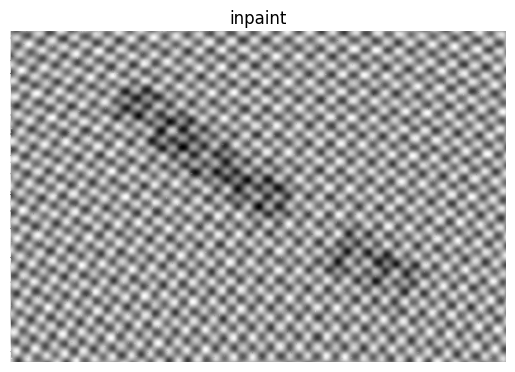

Step: dft
Data type: float32


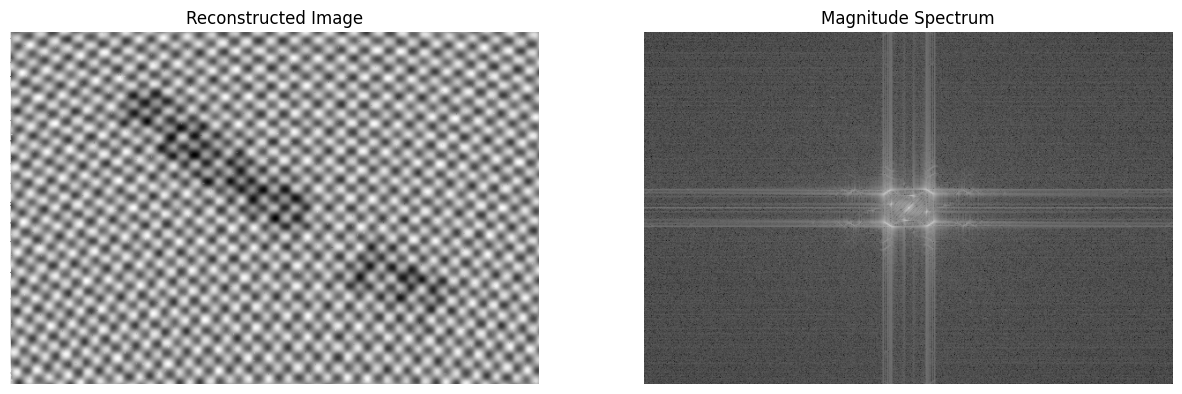

Step: notch0
Data type: float32


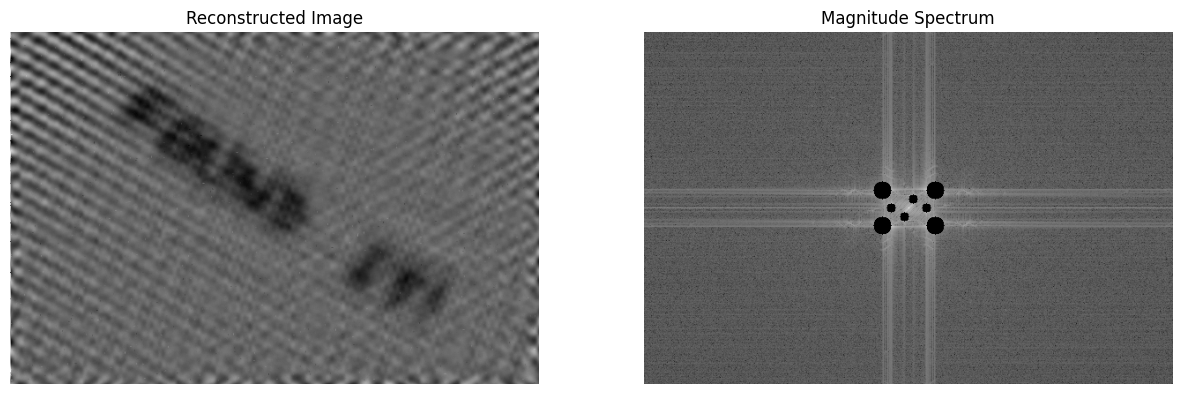

Step: low_pass
Data type: float32


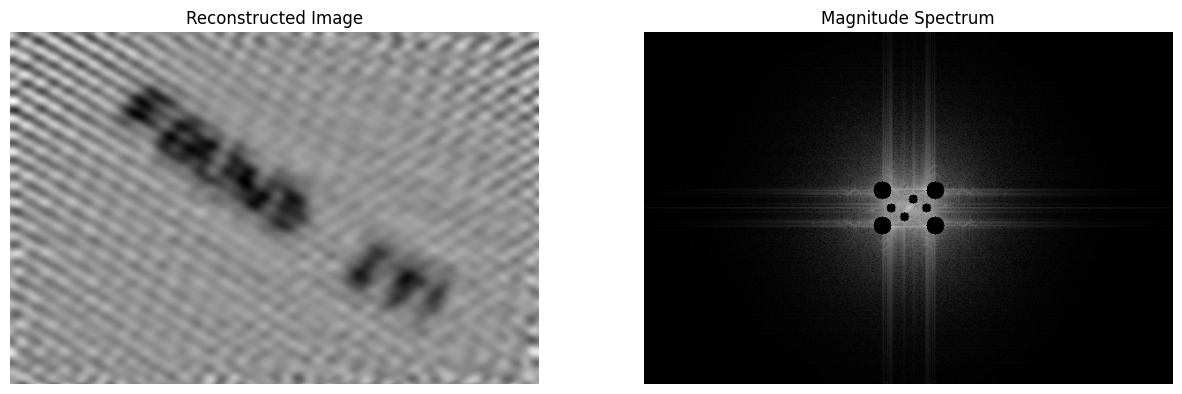

Step: idft
Data type: uint8


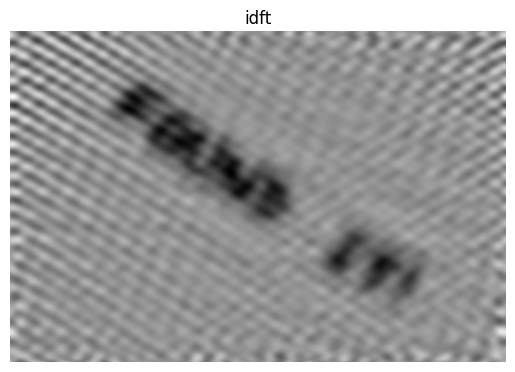

Step: bilateral
Data type: uint8


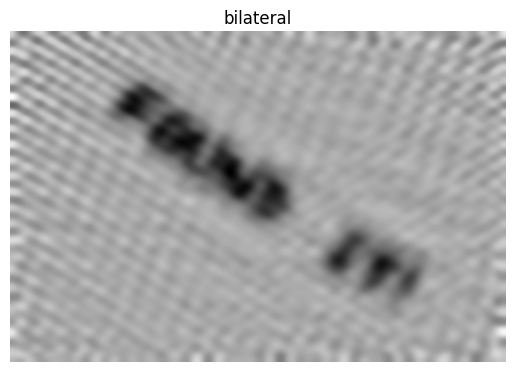

Step: thresholding_inpaint
Data type: uint8


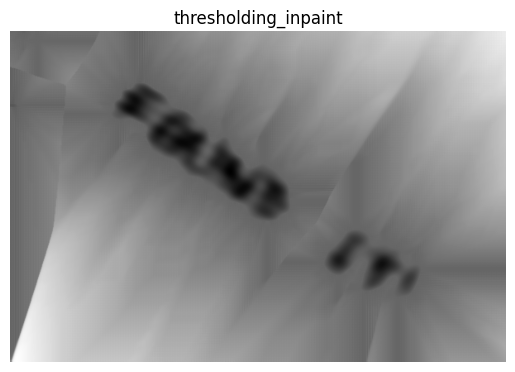

Step: paint
Data type: uint8


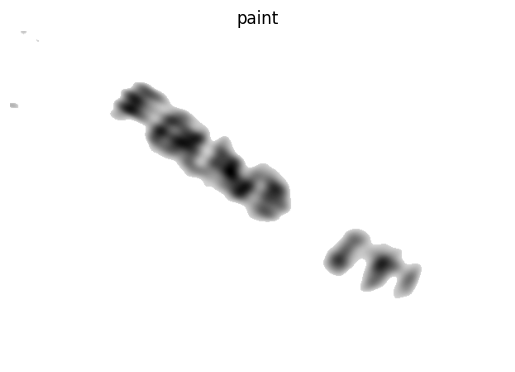

Step: clahe
Data type: uint8


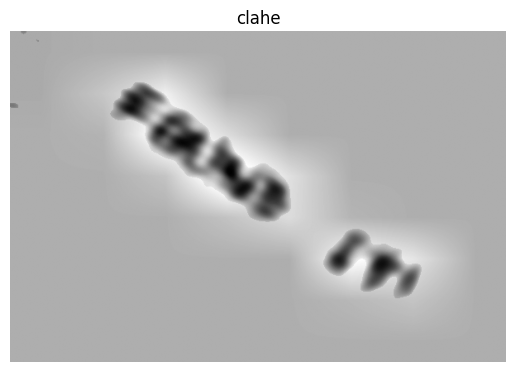

Step: gamma
Data type: uint8


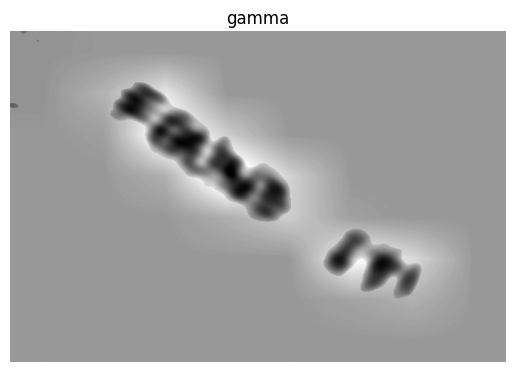

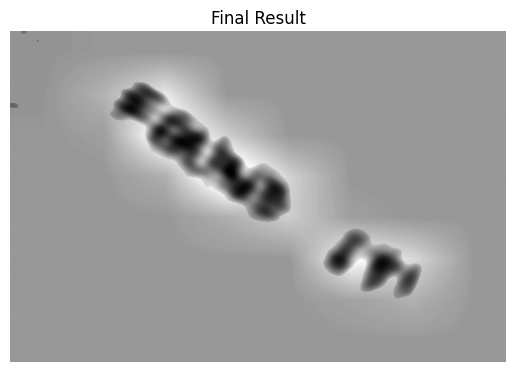

Pipeline completed!


array([[72, 72, 72, ..., 74, 74, 74],
       [72, 72, 72, ..., 74, 74, 74],
       [72, 72, 72, ..., 74, 74, 74],
       ...,
       [74, 74, 74, ..., 74, 74, 74],
       [74, 74, 74, ..., 74, 74, 74],
       [74, 74, 74, ..., 74, 74, 74]], shape=(400, 600), dtype=uint8)

In [359]:

pipeline_order = ["inpaint","dft", "notch0", "low_pass","idft", "bilateral", "thresholding_inpaint","paint" , "clahe", "gamma"]

run_pipeline(data, pipeline_order, debug=True)